# Test Delight Learn 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June  18th 2021
- Update June 23th 2021 : Covariance Matrix

In [355]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [356]:
from matplotlib.colors import LogNorm

In [357]:
from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [358]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [359]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Configuration

- select if want to control Delight internal simulation or DC2

In [360]:
FLAG_DC2=True

In [361]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfilename='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

# Load config and data

In [362]:
params = parseParamFile(configfilename, verbose=False)


comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()


if threadNum == 0:
    logger.info("--- DELIGHT-LEARN ---")


2021-06-24 11:12:52,011 ipykernel_launcher.py, __main__[156] INFO --- DELIGHT-LEARN ---


In [363]:
# Read filter coefficients, compute normalization of filters
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
numBands = bandCoefAmplitudes.shape[0]

redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
sed_names = params['templates_names']
f_mod = readSEDs(params)

In [364]:
band_name=["u","g","r","i","z","y"]
the_coloredmaps=["Blues","Greens","Reds","Oranges","Greys","Purples"]

In [365]:
numBands

6

In [366]:
all_renormmodel=[]
all_fluxes=[]

# Learn

In [367]:
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

msg= 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)


firstLine = int(threadNum * numObjectsTraining / numThreads)
lastLine = int(min(numObjectsTraining,(threadNum + 1) * numObjectsTraining / numThreads))
numLines = lastLine - firstLine

    
msg ='Thread ' +  str(threadNum) + ' , analyzes lines ' + str(firstLine) + ' , to ' + str(lastLine)
logger.info(msg)

DL = approx_DL()


<ipython-input-367-436ba5cc070e>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
2021-06-24 11:12:52,285 ipykernel_launcher.py, __main__[156] INFO Number of Training Objects 3755
2021-06-24 11:12:52,286 ipykernel_launcher.py, __main__[156] INFO Thread 0 , analyzes lines 0 , to 3755


## Templates Model

In [368]:
f_mod.shape

(8, 6)

# Gaussian Processes

In [369]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

Text(0.5, 1.0, 'Redshift grids')

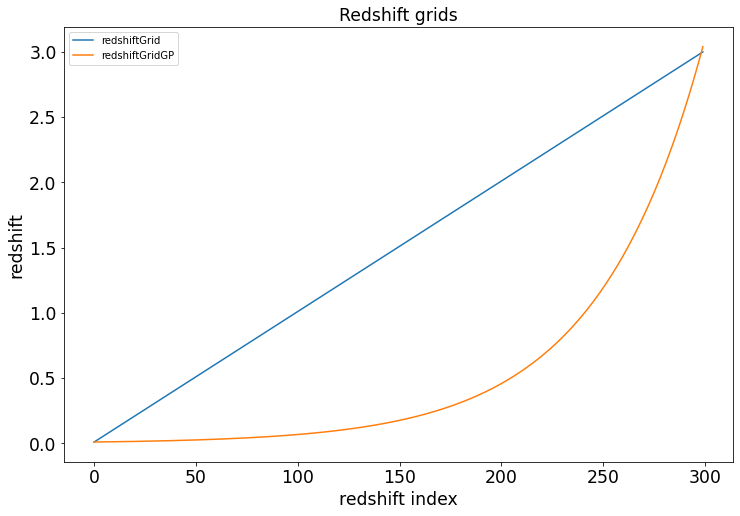

In [370]:
plt.plot(redshiftGrid,label="redshiftGrid")
plt.plot(redshiftGridGP,label="redshiftGridGP")
plt.xlabel("redshift index")
plt.ylabel("redshift")
plt.legend()
plt.title("Redshift grids")

# GP Average function

In [371]:
gp.mean_fct?

Type:           Photoz_linear_sed_basis
String form:    <delight.photoz_kernels.Photoz_linear_sed_basis object at 0x7f875e4b52e0>
File:           ~/.local/lib/python3.8/site-packages/delight/photoz_kernels.py
Docstring:     
Mean function of photoz GP, based on a library of templates.

Args:
    f_mod_interp: grid of interpolators of size (num templates, num bands)
        called as ``f_mod_interp[it, ib](z)``
Init docstring: Constructor.


In [372]:
X=np.zeros((numBands,3))
X[:,0]=np.arange(numBands)
X[:,1]=1.5
X[:,2]=1.0

In [373]:
gp.mean_fct.f(X).shape

(6, 8)

In [374]:
NBINS=20

In [375]:
all_F=[]
all_z=[]
all_X=[]
for z in np.linspace(0.1,3,NBINS):
    X=np.zeros((numBands,3))
    X[:,0]=np.arange(numBands)
    X[:,1]=z
    X[:,2]=1.0
    Fluxes=gp.mean_fct.f(X)
    all_F.append(Fluxes)
    all_z.append(z)
    all_X.append(X)
    

In [376]:
all_X[0].shape

(6, 3)

## Plotting

In [377]:
NR=2  
NC=3   
NT=8

### Select band and template

In [378]:
ib=1 # select band
it=0 # select template
F= [ f[ib,it] for f in all_F ]

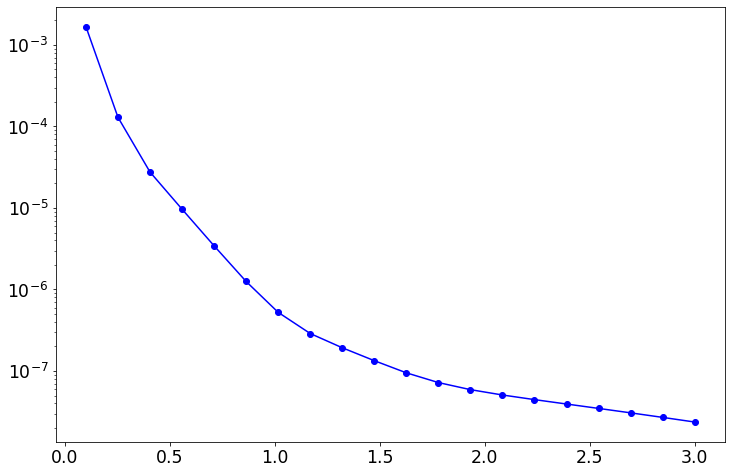

In [379]:
plt.plot(all_z,F,"o-b")
plt.yscale("log")

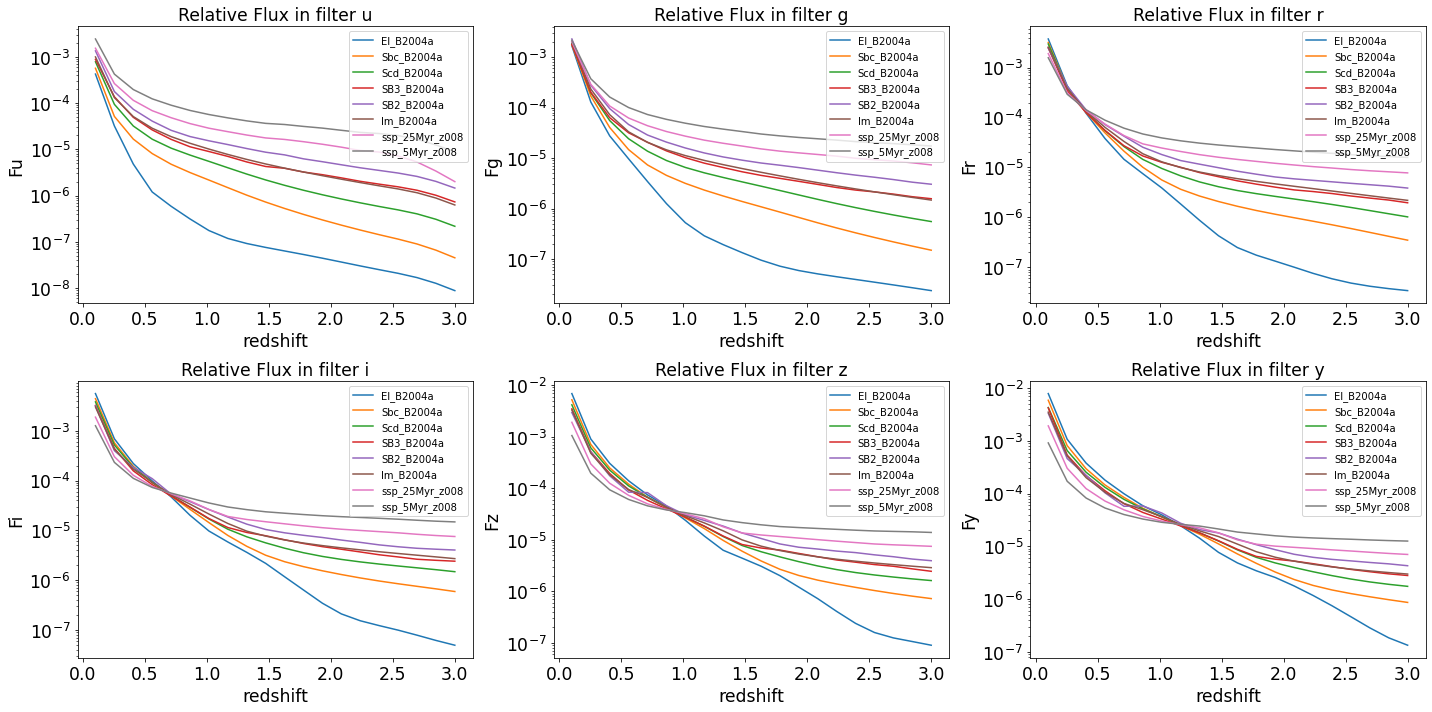

In [380]:
fig, axs = plt.subplots(NR, NC,figsize=(20,10))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib=ic+ir*NC
        
        for it in np.arange(NT):
            F= [ f[ib,it] for f in all_F]
            axs[ir,ic].plot(all_z,F,label=sed_names[it])
            axs[ir,ic].set_yscale("log")
            axs[ir,ic].legend(loc="upper right")
            axs[ir,ic].set_xlabel("redshift")
            axs[ir,ic].set_ylabel("F"+band_name[ib])
            axs[ir,ic].set_title("Relative Flux in filter "+band_name[ib])
            
plt.tight_layout()

# GP Kernel

In [381]:
gp.kernel?

Type:           Photoz_kernel
String form:    <delight.photoz_kernels.Photoz_kernel object at 0x7f875e4b5700>
File:           ~/.local/lib/python3.8/site-packages/delight/photoz_kernels.py
Docstring:     
Photoz kernel based on RBF kernel in SED space.

Args:
    fcoefs_amp: ``numpy.array`` of size (numBands, numCoefs)
        describint the amplitudes of the Gaussians approximating the
        photometric filters.
    fcoefs_mu: ``numpy.array`` of size (numBands, numCoefs)
        describint the positions of the Gaussians approximating the
        photometric filters.
    fcoefs_sig: ``numpy.array`` of size (numBands, numCoefs)
        describint the widths of the Gaussians approximating the
        photometric filters.
    lines_mu: ``numpy.array`` of SED line positions
    lines_sig: ``numpy.array`` of SED line widths
    var_C: GP variance for SED continuum correlations.
        Should be a ``float`, preferably between 1e-3 and 1e2.
    var_L: GP variance for SED line correlations.

In [382]:
gp.kernel.g_AB

1.0

In [383]:
X1=np.zeros((numBands,3))
X1[:,0]=np.arange(numBands)
X1[:,1]=1
X1[:,2]=1.0

In [384]:
X2=np.zeros((numBands,3))
X2[:,0]=np.arange(numBands)
X2[:,2]=1
X2[:,2]=1.0

In [385]:
gp.kernel.K(X1,X2).shape

(6, 6)

In [386]:
def Make_Covariance_Matrix(all_X,ifilt1,ifilt2):
    """
    """
    N=len(all_X)
    
    K=np.zeros((N,N))
    
    for i in np.arange(N):
        X1=all_X[i]
        F1=np.average(gp.mean_fct.f(X1)[ifilt1])
        for j in np.arange(N):
           
            X2=all_X[j]
            F2=np.average(gp.mean_fct.f(X2)[ifilt2])
            K[i,j]=gp.kernel.K(X1,X2)[ifilt2,ifilt1]/(F1*F2)          
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            

In [387]:
def Make_Covariance_Matrix_nonorm(all_X,ifilt1,ifilt2):
    """
    """
    N=len(all_X)
    
    K=np.zeros((N,N))
    
    for i in np.arange(N):
        X1=all_X[i]
        F1=np.average(gp.mean_fct.f(X1)[ifilt1])
        for j in np.arange(N):
           
            X2=all_X[j]
            F2=np.average(gp.mean_fct.f(X2)[ifilt2])
            K[i,j]=gp.kernel.K(X1,X2)[ifilt2,ifilt1]       
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            

In [388]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]

In [389]:
NR=6  
NC=6   

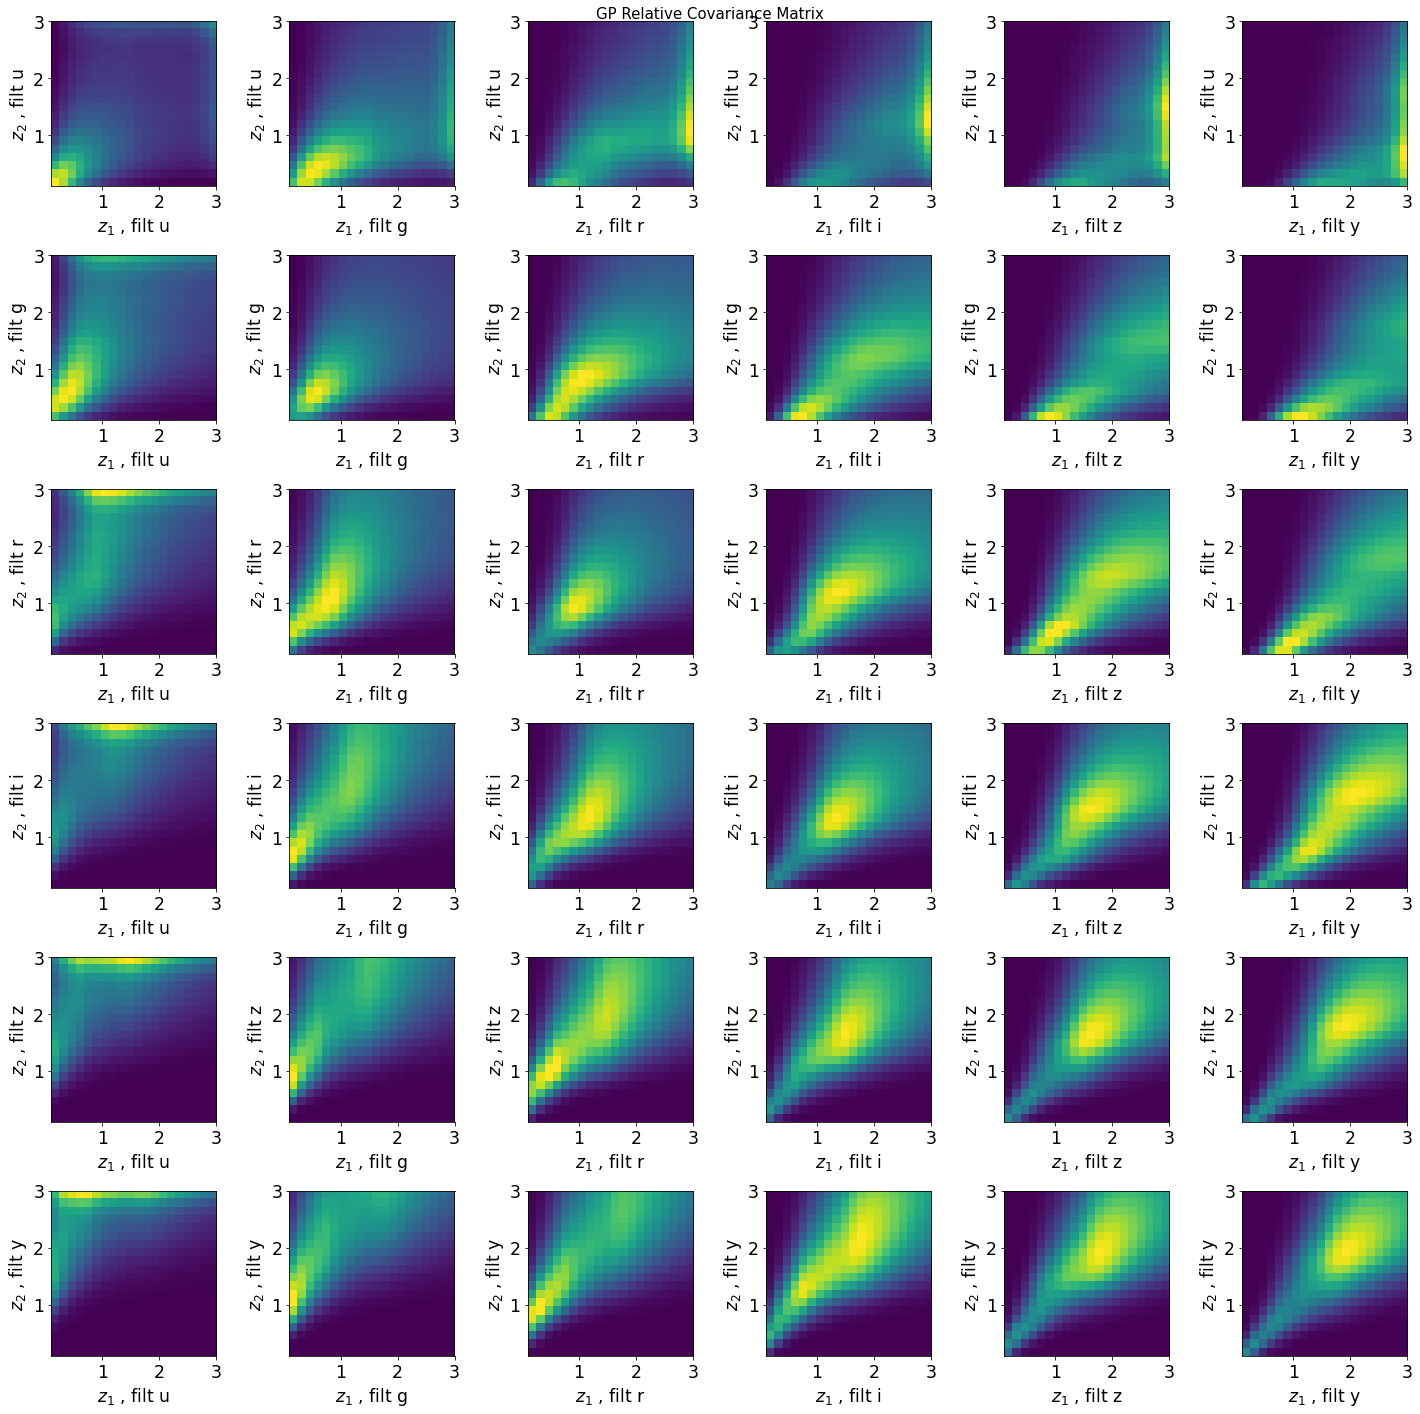

In [390]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
plt.suptitle("GP Relative Covariance Matrix",fontsize=15)
plt.tight_layout()        

# Generate random priors on Flux Function

In [391]:
ib=0 # select band
it=0 # select template
F= [ f[ib,it] for f in all_F ]

In [399]:
mu=np.zeros(NBINS)

In [411]:
C=Make_Covariance_Matrix_nonorm(all_X,ib,5)

In [394]:
C.shape

(20, 20)

In [406]:
NSIM=20

In [412]:
F_gp  = np.random.multivariate_normal(mu, C, NSIM)

In [408]:
F_gp.shape

(20, 20)

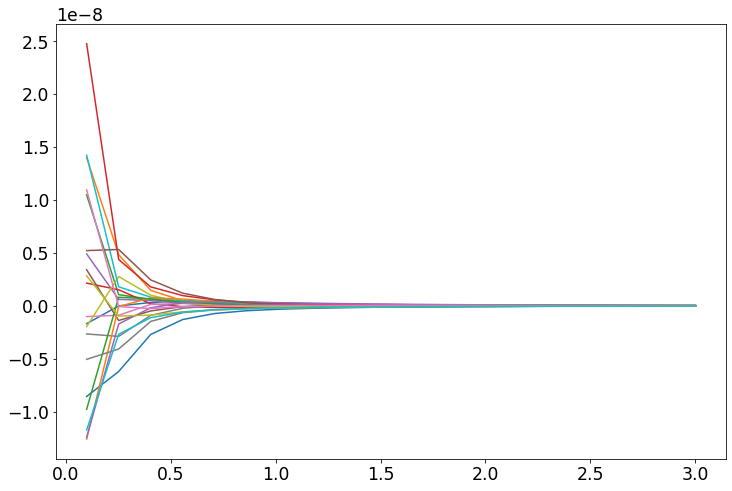

In [413]:
#plt.plot(all_z,F,"k-",lw=3)
for idx in np.arange(NSIM):

    plt.plot(all_z,F_gp[idx,:])
    
#plt.yscale("log")

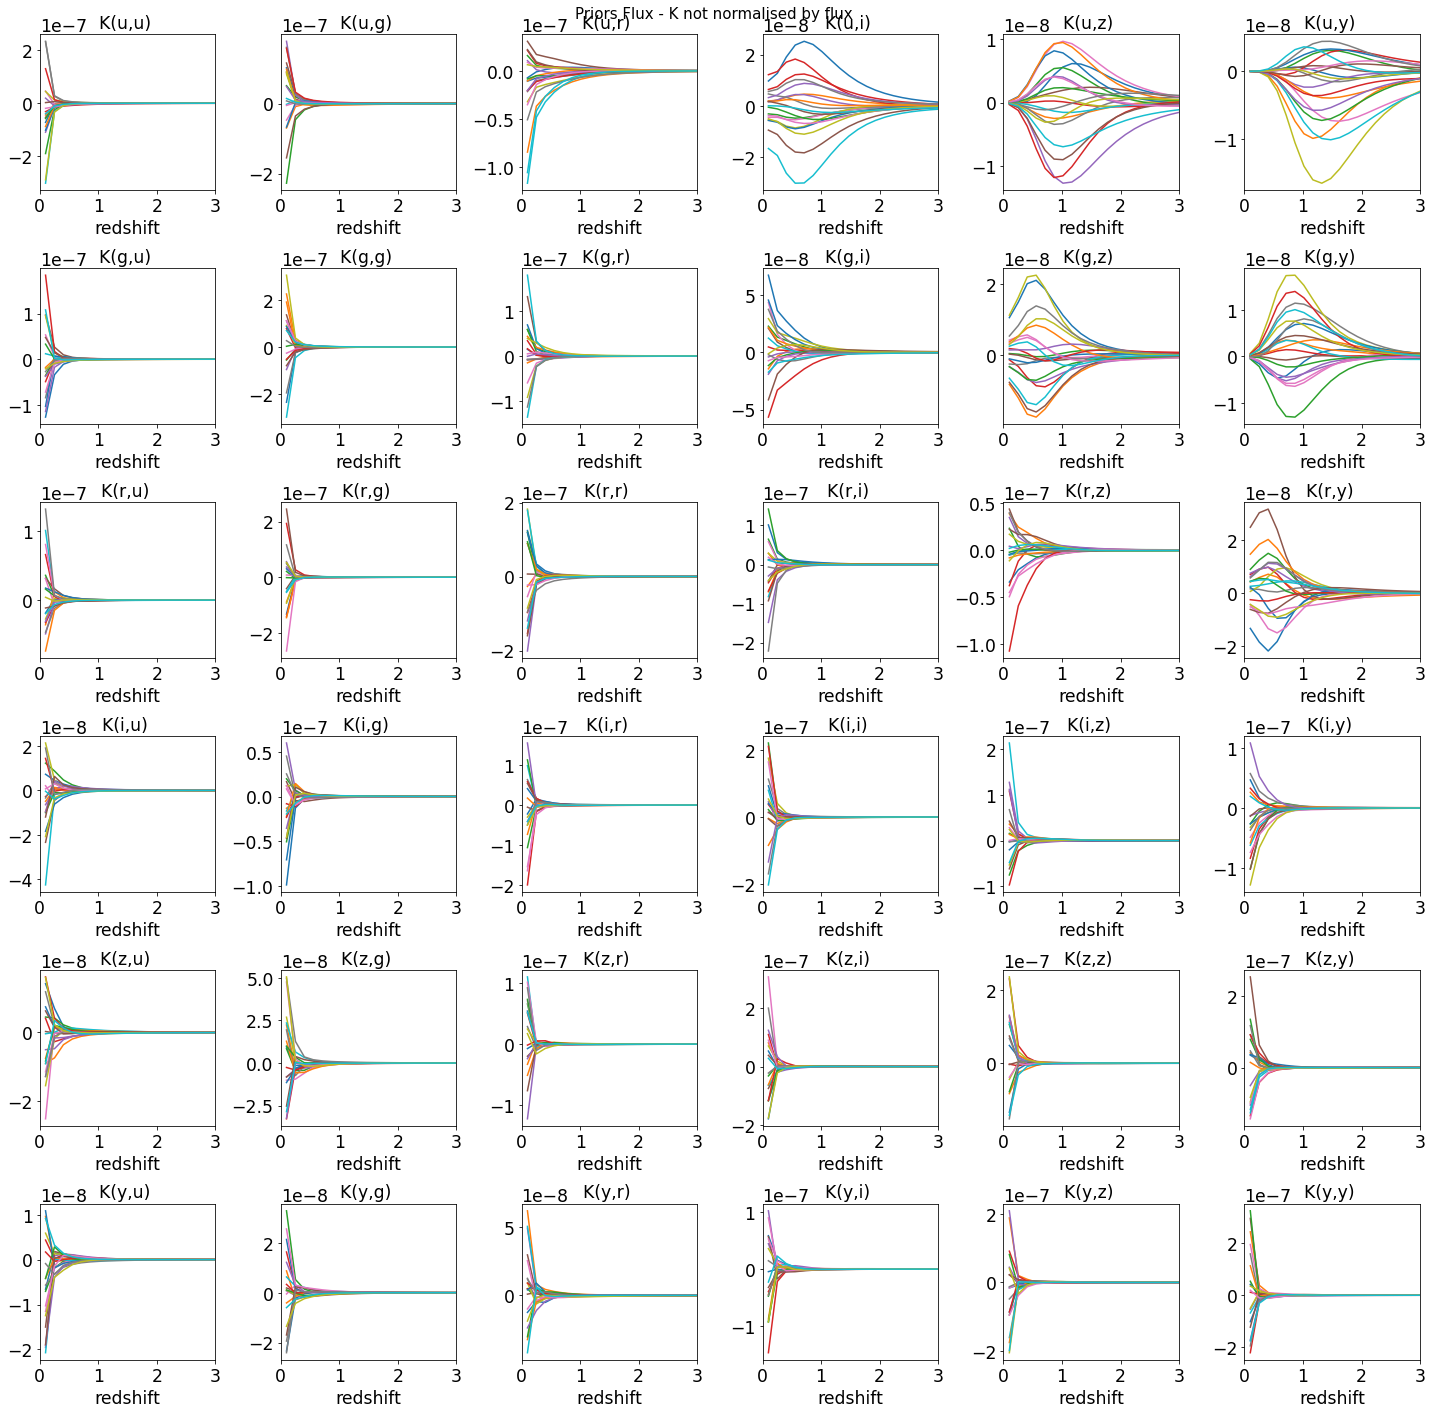

In [415]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        
plt.suptitle("Priors Flux - K not normalised by flux ",fontsize=15)
plt.tight_layout()      

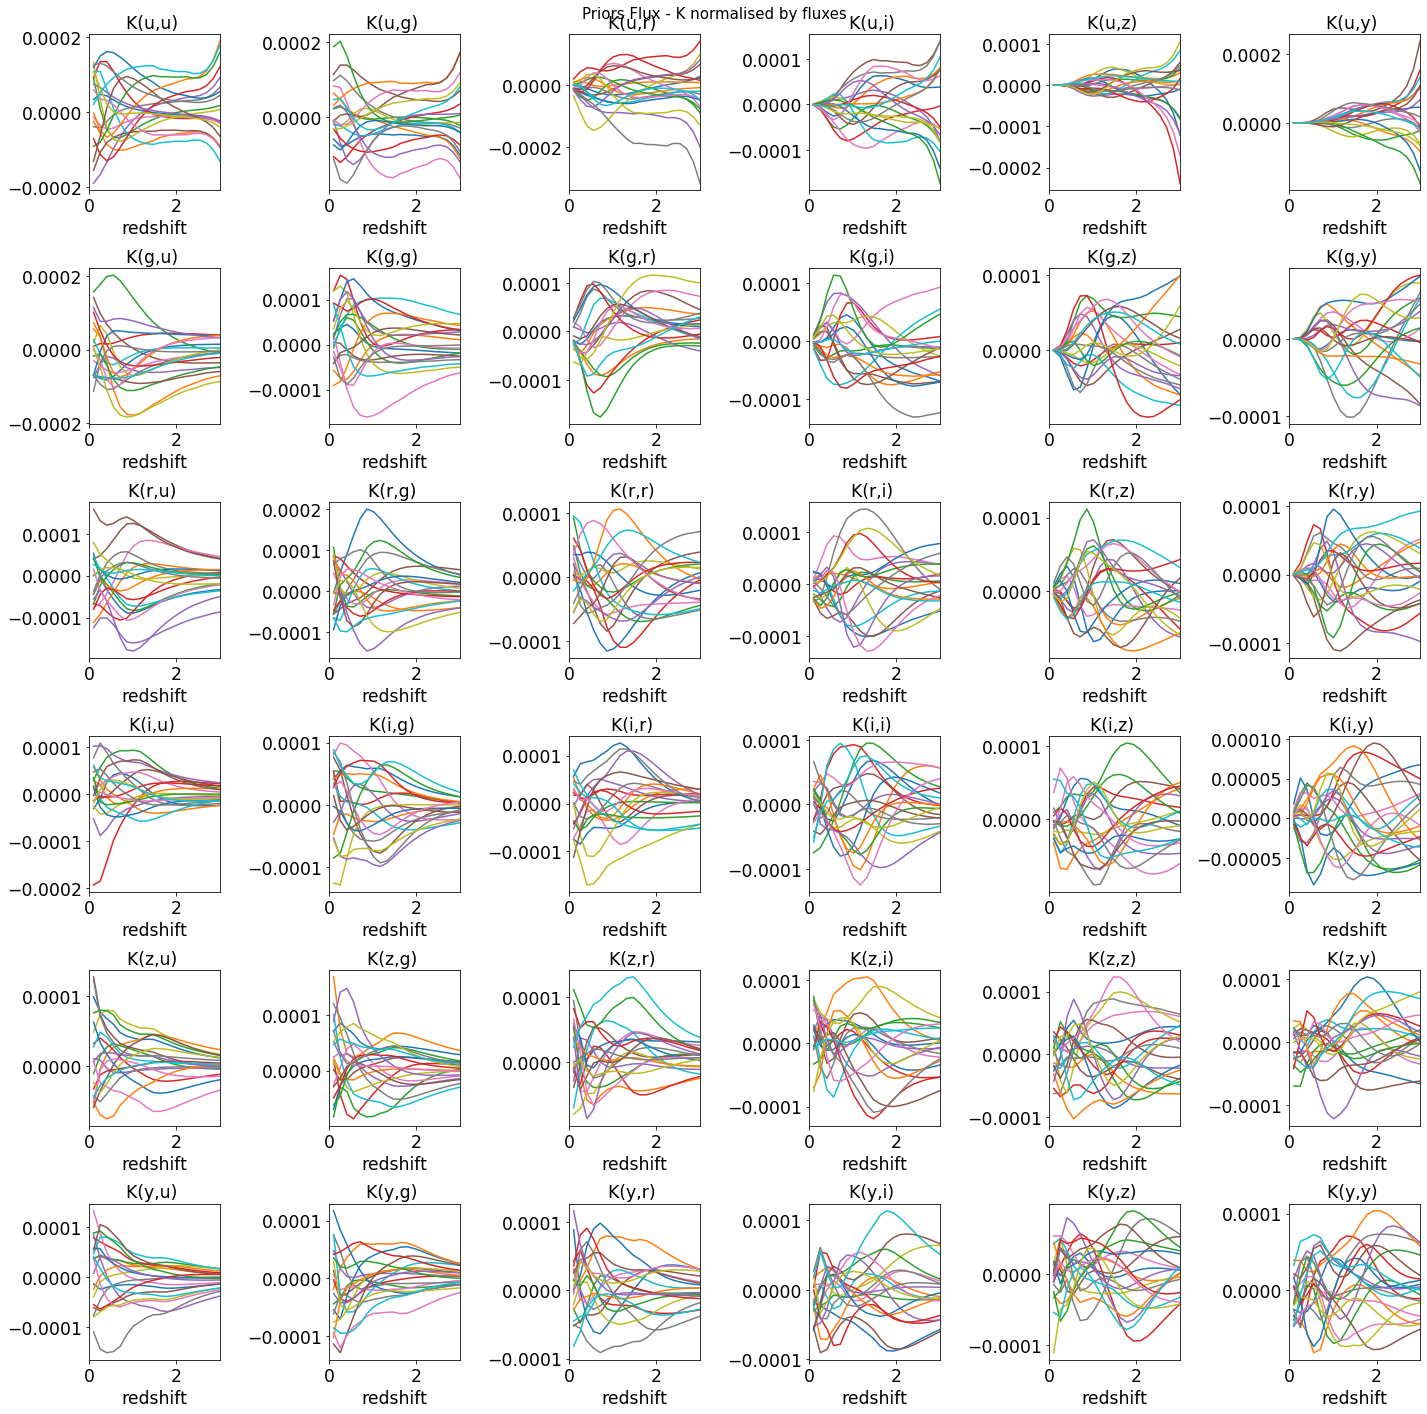

In [416]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        
plt.suptitle("Priors Flux - K normalised by fluxes ",fontsize=15)
plt.tight_layout()      